In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
from caffe import layers as L

# matplotlib config
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
caffe.set_device(0)
caffe.set_mode_gpu()

from train_places_net import MEAN, minivggnet, to_tempfile, get_split

def load_net(i, labels):
    with open(get_split('val'), 'r') as fh:
        images = fh.read().split("\n")
    print("True category is: {}".format(labels[int(images[i].split(" ")[1])]))
    source = to_tempfile(images[i])

    transform_param = dict(mirror=False, crop_size=96, mean_value=MEAN)
    places_data, places_labels = L.ImageData(
        transform_param=transform_param,
        source=source, root_folder='./images/', 
        shuffle=False, batch_size=1, ntop=2)
    net_path = minivggnet(
        data=places_data, labels=places_labels,
        train=False, cudnn=False, with_labels=False)
    
    net = caffe.Net(net_path, 'snapshot/place_net_iter_10000.caffemodel', caffe.TEST)

    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.array(MEAN)) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    
    return net, transformer

True category is: /i/ice_skating_rink/outdoor
Predicted class is /a/aquarium

/a/aquarium (p=0.057151440531)
/b/bakery/shop (p=0.0566648840904)
/r/restaurant (p=0.0415375679731)
/b/boat_deck (p=0.036573279649)
/c/coffee_shop (p=0.0321928709745)


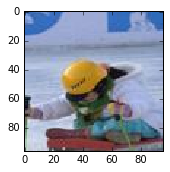

In [80]:
def predict(i):
    # load labels
    labels_filename = 'development_kit/data/categories.txt'
    labels = np.loadtxt(labels_filename, str, delimiter=' ')[:, 0]

    # load network
    net, transformer = load_net(i, labels)

    # compute predictions
    out = net.forward()
    probs = out['probs'][0]
    print("Predicted class is {}\n".format(labels[probs.argmax()]))
    
    # sort top k predictions from softmax output
    top_k = probs.argsort()[::-1][:5]
    categories = labels[top_k]
    for cat, p in zip(categories, probs[top_k]):
        print("{} (p={})".format(cat, p))
    
    image = transformer.deprocess('data', net.blobs['data'].data[0])
    plt.imshow(image)
    fig = plt.gcf()
    fig.set_size_inches(2.5, 2.5)

    return net

net = predict(32)

Helper functions for visualization

In [35]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

## Layer 1

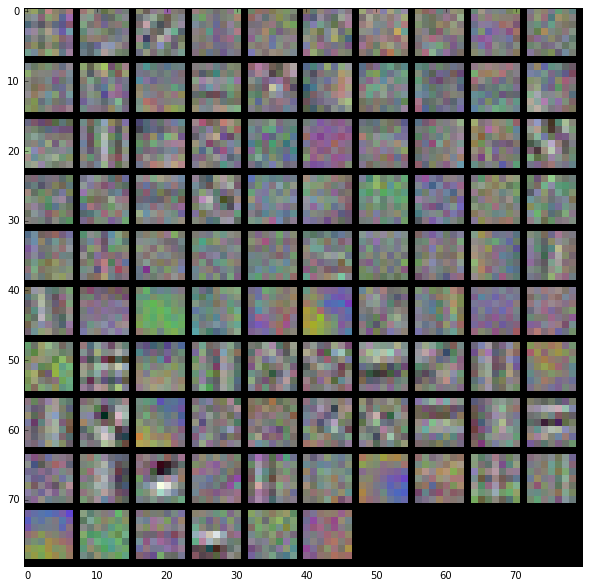

In [36]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

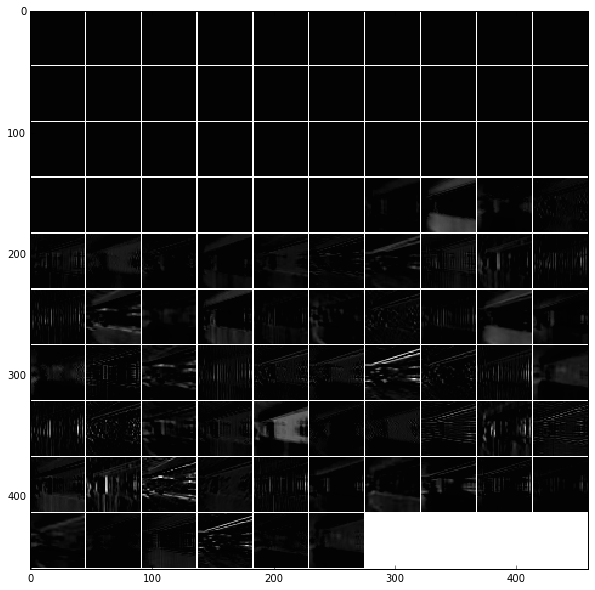

In [39]:
feat = net.blobs['conv1'].data[0]
vis_square(feat, padval=1)

## Layer 2

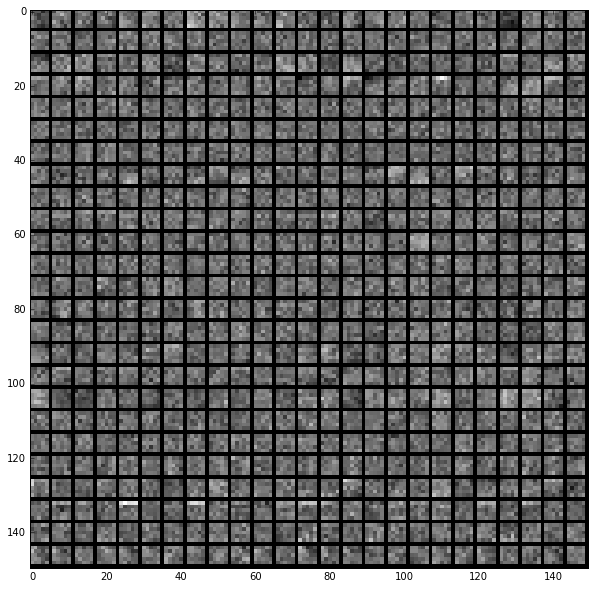

In [38]:
filters = net.params['conv2'][0].data
vis_square(filters[:25, :25].reshape(25**2, 5, 5))

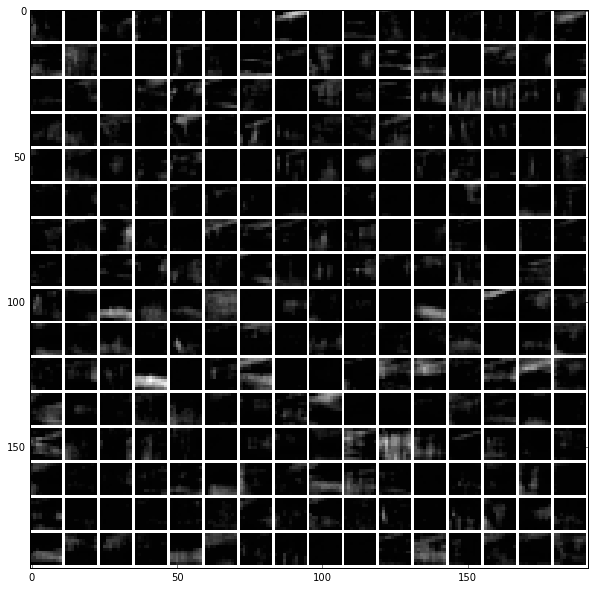

In [40]:
feat = net.blobs['conv2'].data[0]
vis_square(feat, padval=1)

## Layer 3

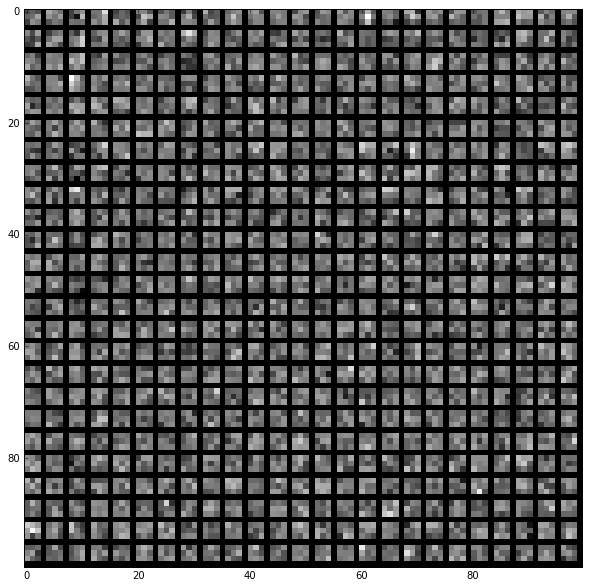

In [41]:
filters = net.params['conv3'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

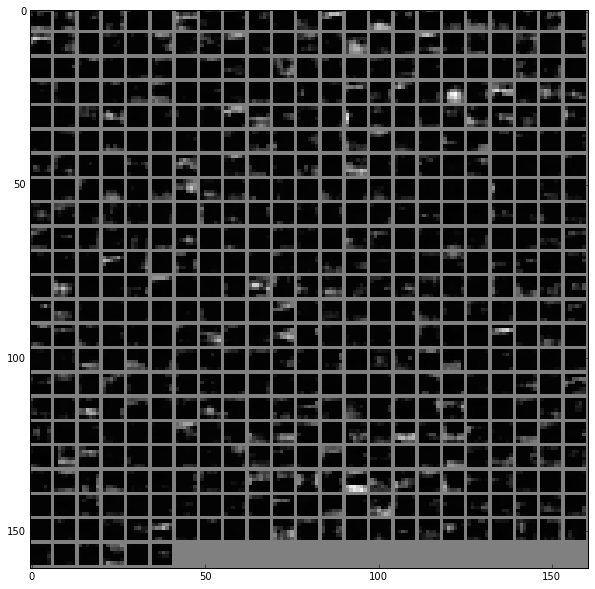

In [42]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

## Layer 4

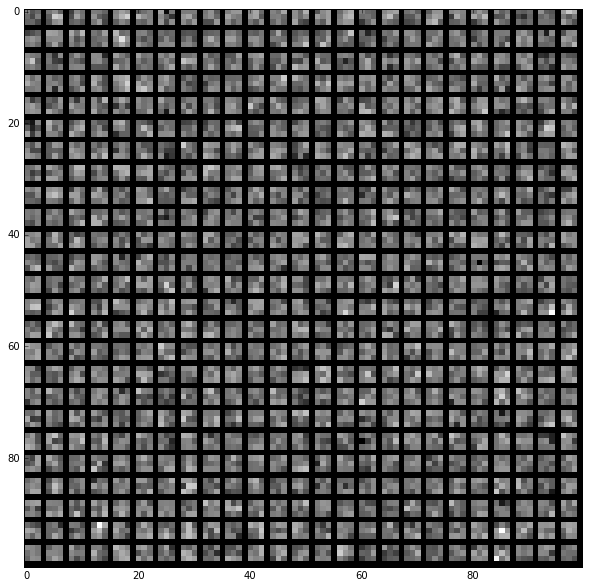

In [43]:
filters = net.params['conv4'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

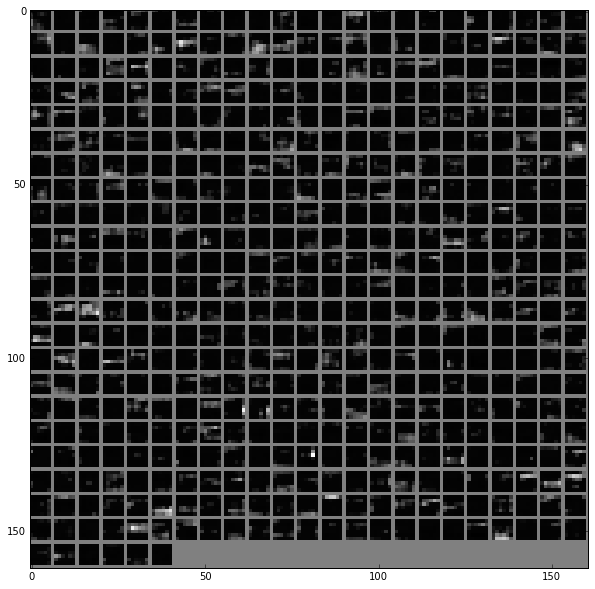

In [44]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

## Layer 5

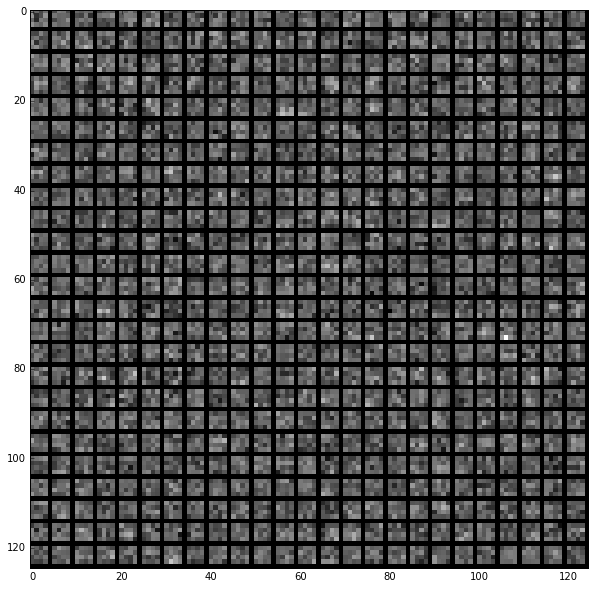

In [45]:
filters = net.params['conv5'][0].data
vis_square(filters[:25, :25].reshape(25**2, 4, 4))

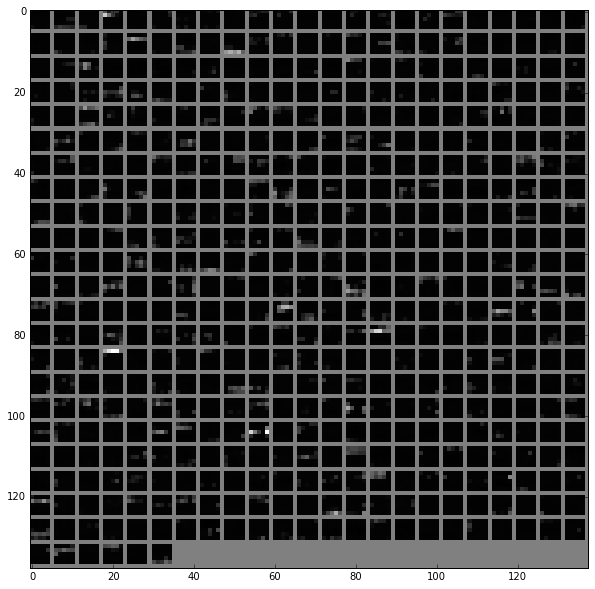

In [46]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

## Layer 6

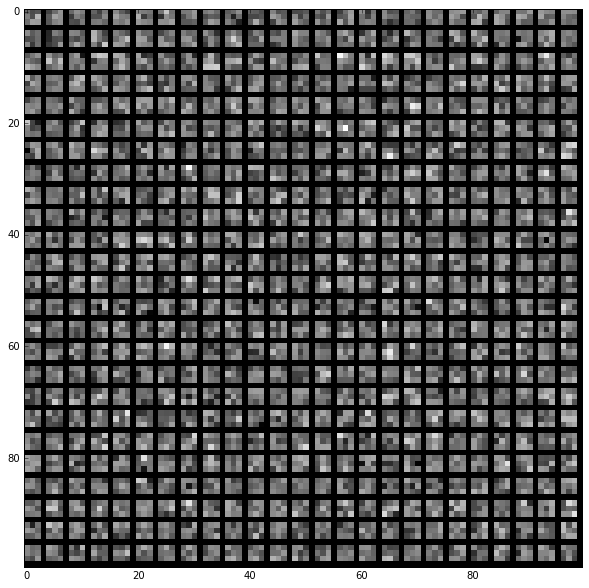

In [47]:
filters = net.params['conv6'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

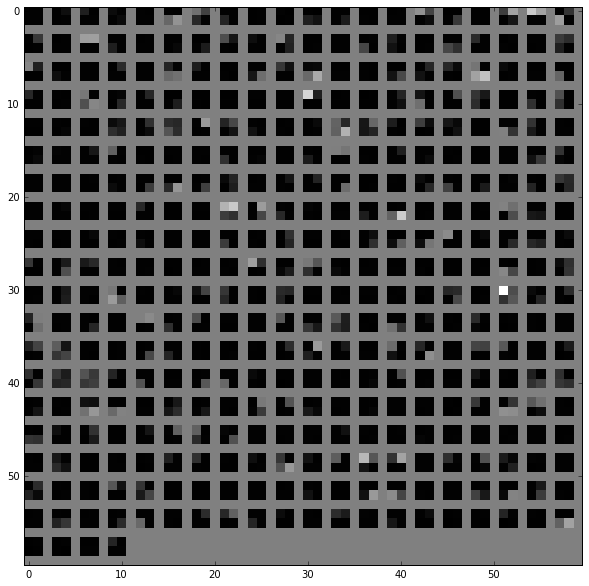

In [48]:
feat = net.blobs['conv6'].data[0]
vis_square(feat, padval=0.5)

## Layer 7

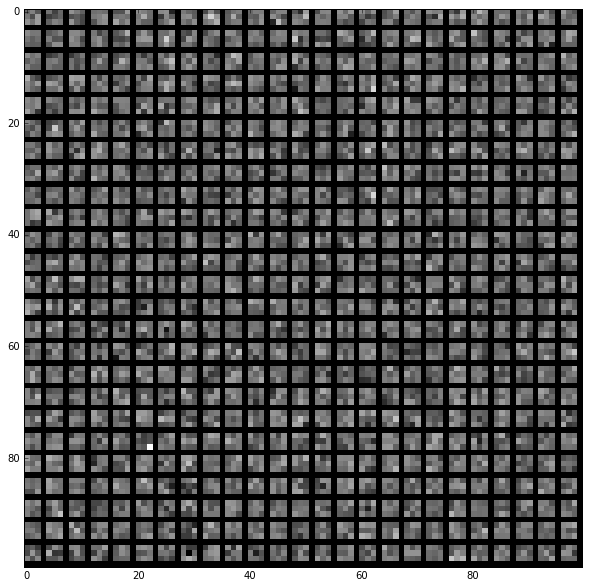

In [49]:
filters = net.params['conv7'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

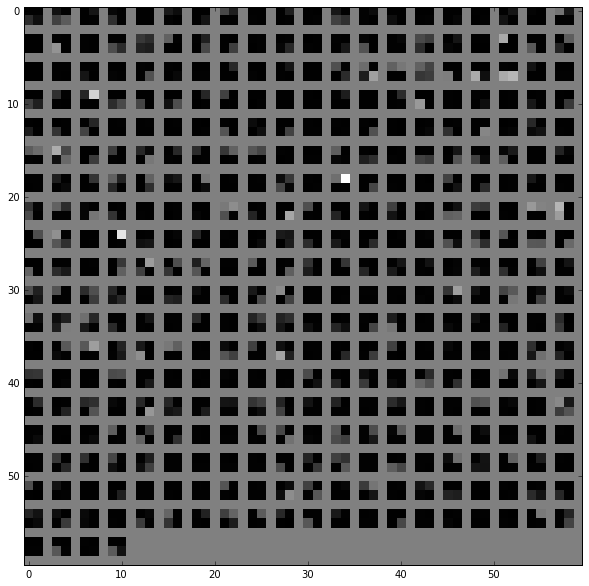

In [50]:
feat = net.blobs['conv7'].data[0]
vis_square(feat, padval=0.5)

## Layer 8

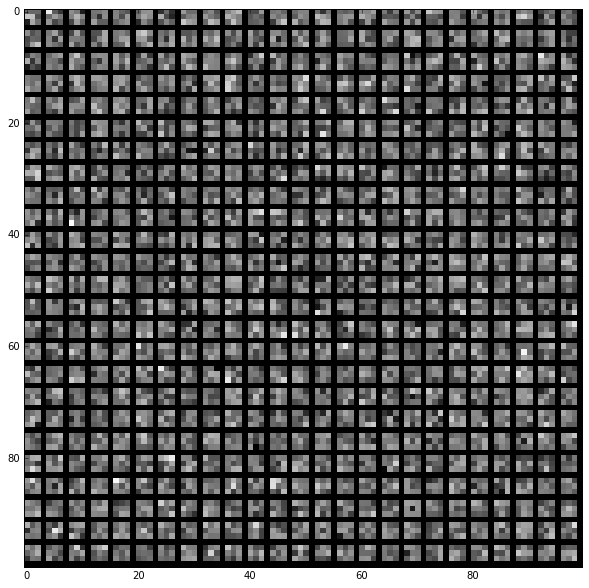

In [51]:
filters = net.params['conv8'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

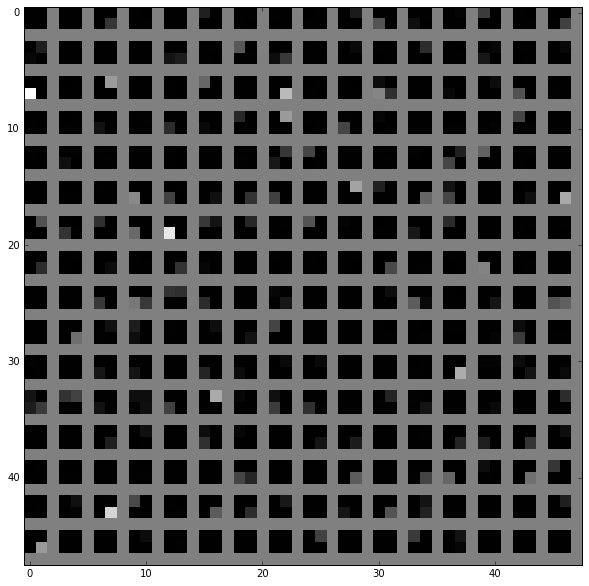

In [52]:
feat = net.blobs['conv8'].data[0]
vis_square(feat, padval=0.5)

The eighth layer after pooling, `pool8`

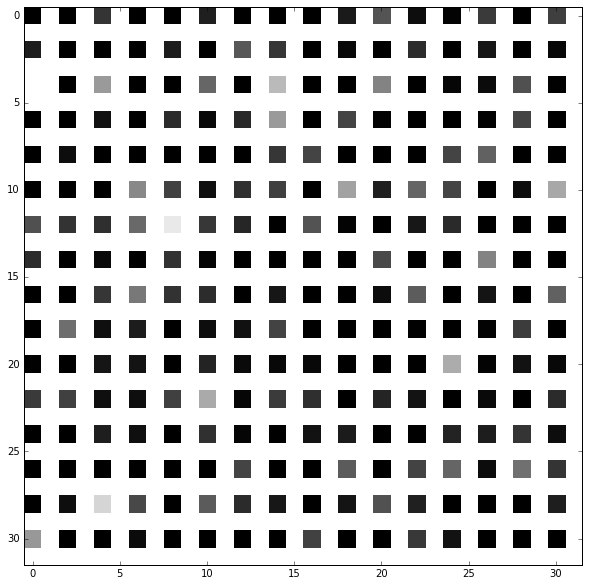

In [53]:
feat = net.blobs['pool8'].data[0]
vis_square(feat, padval=1)

## Layer 9

The first fully connected layer, `fc9`

We show the output values and the histogram of the positive values

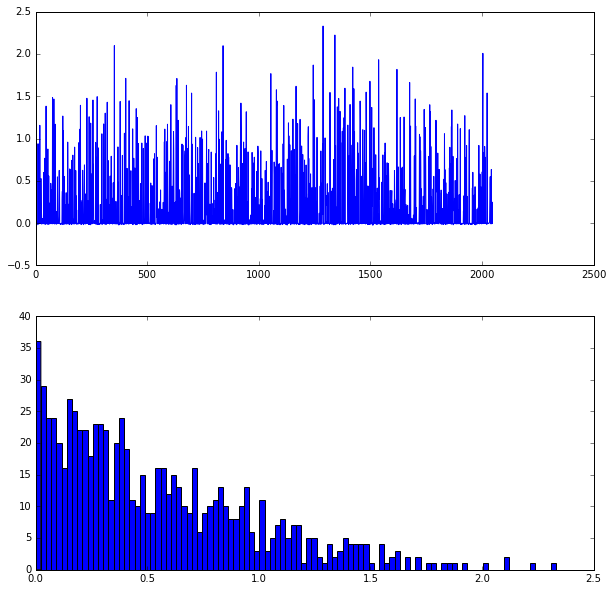

In [54]:
feat = net.blobs['fc9'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

## Layer 10

The second fully connected layer, `fc10` (rectified)

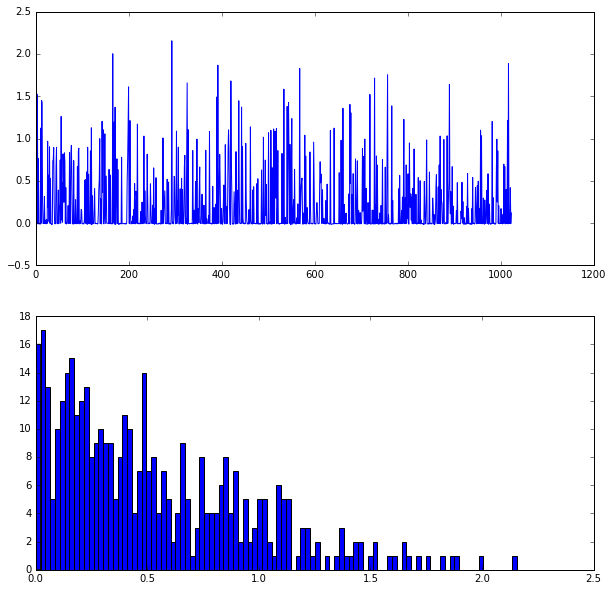

In [55]:
feat = net.blobs['fc10'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

## Output layer

The final probability output, `prob`

(-0.5, 100.5)

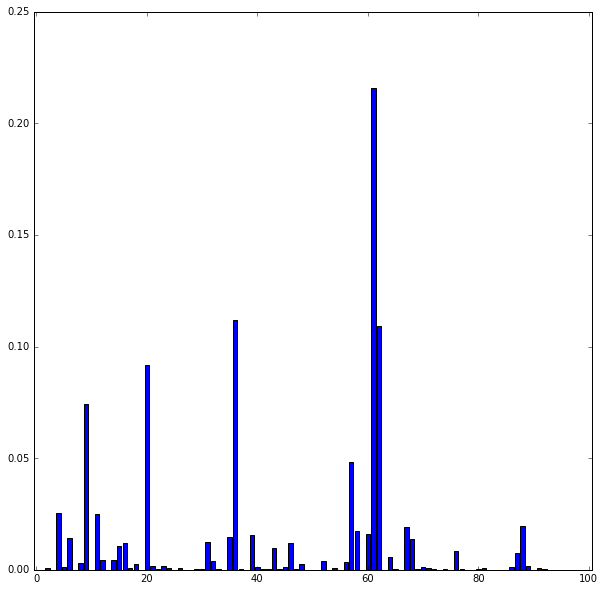

In [56]:
feat = net.blobs['probs'].data[0].flat
fig, ax = plt.subplots()
ax.bar(np.arange(len(feat)), feat, align='center')
ax.set_xlim(-0.5, 100.5)